# Make All Figures for Main Manuscript

Kendra Wyant  
August 20, 2025

In [ ]:
#| message: false
#| warning: false

suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(source("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true"))
suppressPackageStartupMessages(library(tidyposterior))
library(kableExtra, exclude = "group_rows")
library(patchwork)

theme_set(theme_classic())

path_models_lag <- format_path(str_c("risk/models/lag"))
path_shared <- format_path("risk/data_processed/shared")
path_processed <- format_path("risk/data_processed/lag")

Data for figures

In [ ]:
pp_tidy <- read_csv(here::here(path_models_lag, "posteriors.csv"), 
                                 show_col_types = FALSE) 

ci <- read_csv(here::here(path_models_lag, "pp_perf_tibble.csv"), 
                                 show_col_types = FALSE) |> 
  mutate(model = factor(model, levels = c("0 lag", "24 lag", "72 lag", "168 lag", "336 lag"),
                        labels = c("No lag", "1 day", "3 days", "1 week", "2 weeks")))

preds_0 <- read_rds(here::here(path_models_lag, 
                               "final_preds_kfold_1_x_5_1day_0_v3_strat_lh_final.rds")) 
preds_24 <- read_rds(here::here(path_models_lag, 
                               "final_preds_kfold_1_x_5_1day_24_v3_strat_lh_final.rds")) 
preds_72 <- read_rds(here::here(path_models_lag, 
                               "final_preds_kfold_1_x_5_1day_72_v3_strat_lh_final.rds")) 
preds_168 <- read_rds(here::here(path_models_lag, 
                               "final_preds_kfold_1_x_5_1day_168_v3_strat_lh_final.rds")) 
preds_336 <- read_rds(here::here(path_models_lag, 
                               "final_preds_kfold_1_x_5_1day_336_v3_strat_lh_final.rds")) 


shap_grp_0 <- read_rds(here::here(path_models_lag, 
                      "final_shapsgrp_kfold_1_x_5_1day_0_v3_strat_lh_final.rds")) |> 
   filter(str_detect(variable_grp, "EMA")) |> 
   mutate(variable_grp = str_remove(variable_grp, "\\(EMA item\\)"))  

shap_grp_336 <- read_rds(here::here(path_models_lag, 
                      "final_shapsgrp_kfold_1_x_5_1day_336_v3_strat_lh_final.rds")) |> 
   filter(str_detect(variable_grp, "EMA")) |> 
  mutate(variable_grp = str_remove(variable_grp, "\\(EMA item\\)"))  

shap_global <- shap_grp_0 |> 
  mutate(model = "No lag") |> 
  bind_rows(shap_grp_336 |> 
              mutate(model = "2 weeks")) |> 
  mutate(model = factor(model, levels = c("2 weeks", "No lag" ))) |> 
  group_by(variable_grp, model) |> 
  summarize(mean_value = mean(abs(value)), .groups = "drop")

shap_levels <- shap_global |>
  mutate(variable_grp = reorder(variable_grp, mean_value, sum)) |>
  pull(variable_grp) |>
  levels()

## Figure 1: Prediction Methods

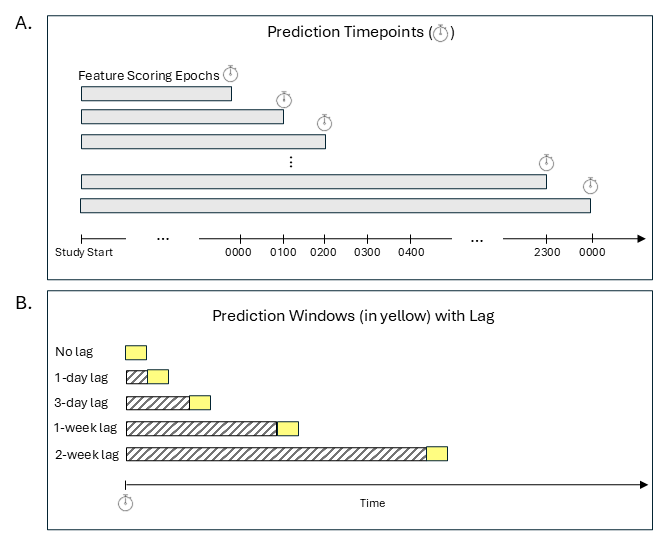

In [ ]:
#| label: fig-method
#| fig-cap: "Panel A shows the prediction timepoints at which our model calculated a predicted probability of a lapse. All available data up until, but not including, the prediction timepoint was used to generate these predictions. Features were created for varying feature scoring epochs before the prediction timepoint (i.e., 12, 24, 48, 72, and 168 hours). Prediction timepoints were updated hourly. Panel B shows how the prediction window (i.e., window in which a lapse might occur) rolls forward hour-by-hour with the prediction timepoint. The prediction window width for all models was 24 hours. Additionally, there were five possible lag times between the prediction timepoint and start of the prediction window. A prediction window either started immediately after the prediction timepoint (no lag) or was lagged by 1 day, 3 days, 1 week, or 2 weeks."

knitr::include_graphics(path = here::here("figures/methods.png"), error = FALSE)

## Figure 2: Posterior probabilities for auROC by model

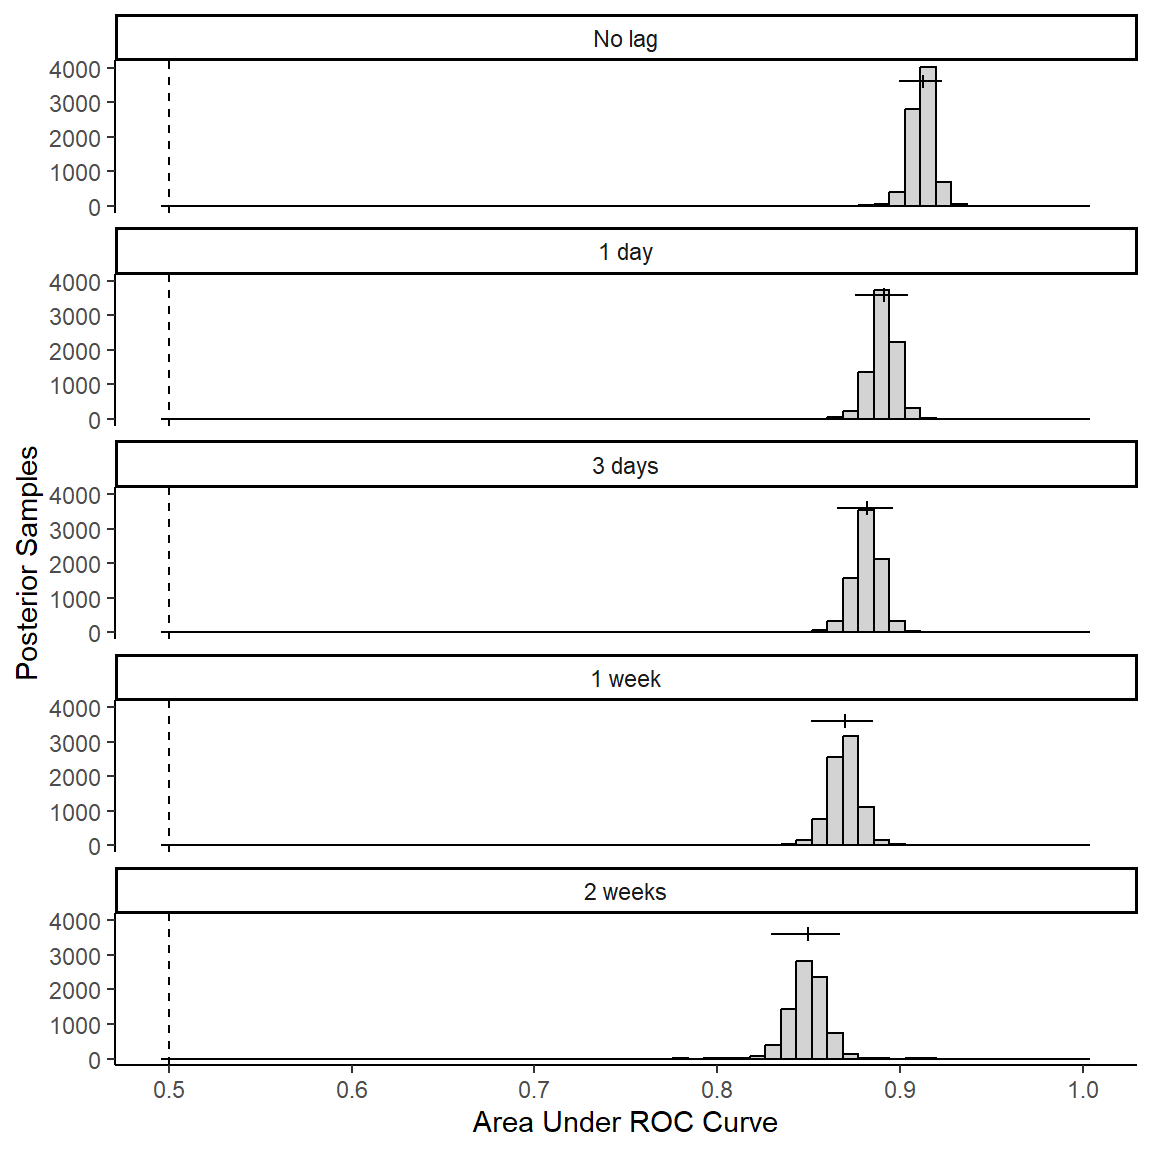

In [ ]:
#| label: fig-pp
#| fig-cap: "Posterior probability distributions for area under ROC curve (auROC) for each model (no lag, 1-day, 3-day, 1-week, and 2-week lag). Each distribution reflects 8,000 posterior samples (4 chains × 2,000 samples) from a Bayesian hierarchical generalized linear model. Horizonatal lines depict 95% Bayesian credible intervals (CI) and vertical solid lines depict median posterior probability for auROC. Vertical dashed line represents expected performance from a random classifier (.5 auROC)."
#| fig-width: 6
#| fig-height: 6

pp_tidy |> 
  mutate(model = factor(model, levels = c("lag0", "lag24", "lag72", "lag168", "lag336"),
                        labels = c("No lag", "1 day", "3 days", "1 week", "2 weeks"))) |>
  ggplot() + 
  geom_histogram(aes(x = posterior), fill = "light grey", color = "black", linewidth = .5,  
                 bins = 60) +
  geom_segment(mapping = aes(y = 3400, yend = 3800, x = pp_median, xend = pp_median),
               linewidth = .5, data = ci) +
  geom_segment(mapping = aes(y = 3600, yend = 3600, x = pp_lower, xend = pp_upper),
                linewidth = .5, data = ci) +
  facet_wrap(~model, ncol = 1) +
  geom_vline(xintercept = .5, linewidth = .5, linetype = "dashed") +
  scale_y_continuous("Posterior Samples") +
  xlab("Area Under ROC Curve") +
  expand_limits(x = c(.5, 1)) +
  theme_classic() 

## Figure 3: Calibrated Model Performance

In [ ]:
bin_width = 0.10

preds_all_raw <- preds_0 |> 
  mutate(bins = cut(prob_raw, breaks = seq(0, 1, bin_width)), 
         lapse = if_else(label == "Lapse", 1, 0)) |> 
  mutate(model = "No lag") |> 
  bind_rows(preds_336 |> 
              mutate(bins = cut(prob_raw, breaks = seq(0, 1, bin_width)), 
                     lapse = if_else(label == "Lapse", 1, 0)) |> 
              mutate(model = "2 weeks")) |> 
  mutate(model = factor(model, levels = c("No lag", "1 day", "3 days", "1 week", "2 weeks")),
         prob = "Raw (uncalibrated)")


preds_all_logi <- preds_0 |> 
  mutate(bins = cut(prob_logi, breaks = seq(0, 1, bin_width)), 
         lapse = if_else(label == "Lapse", 1, 0)) |> 
  mutate(model = "No lag") |> 
  bind_rows(preds_336 |> 
              mutate(bins = cut(prob_logi, breaks = seq(0, 1, bin_width)), 
                     lapse = if_else(label == "Lapse", 1, 0)) |> 
              mutate(model = "2 weeks")) |> 
  mutate(model = factor(model, levels = c("No lag", "1 day", "3 days", "1 week", "2 weeks")),
         prob = "Platt calibration")

preds_all <- preds_all_raw |> 
  bind_rows(preds_all_logi) 

mini_hist <- preds_all_raw |>
  count(bins, model) |> 
  bind_rows(tibble(bins = "(0.9,1]",
                   model = "2 weeks",
                   n = 0)) |> 
  group_by(model) |> 
  mutate(
    bins = seq(1, 10, 1),
    x = bin_width / 2 + bin_width * (bins - 1),       
    y = n / max(n) * 0.07
  ) |> 
  mutate(model = factor(model, levels = c("No lag", "2 weeks"))) 

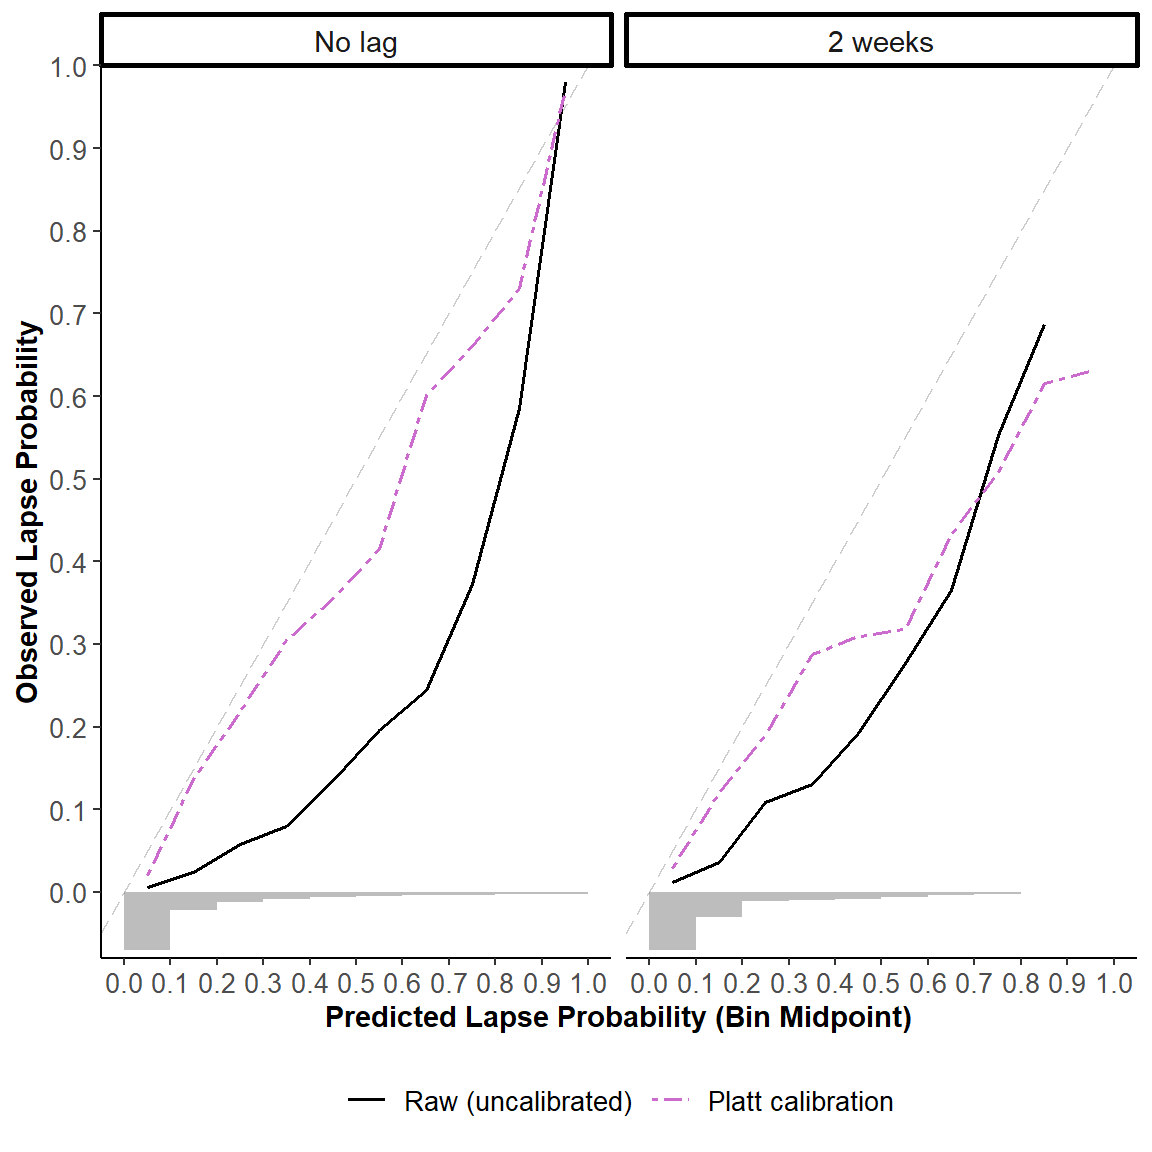

In [ ]:
#| label: fig-cal
#| fig-cap: "Calibration plots of raw and calibrated lapse probabilities for the baseline (no lag) and 2-week lagged models. Predicted probabilities (x-axis) are binned into deciles. Observed lapse probability (y-axis) represents the proportion of actual lapses observed in each bin. The dashed diagonal represents perfect calibration. Points below the line indicate overestimation and points above the line indicate underestimation. Raw probabilities are depicted as solid black curves. Platt calibrated probabilites are depicted as pink dashed curves. The grey histogram along the bottom of the plot represents the proportion of raw probabilities in each bin."
#| fig-width: 6
#| fig-height: 6

preds_all |> 
  mutate(prob = factor(prob, levels = c("Raw (uncalibrated)", 
                                        "Platt calibration"))) |> 
  group_by(bins, model, prob)  |> 
  summarize(mean_lapse = mean(lapse), .groups = "drop") |> 
  mutate(
    bins = as.numeric(bins),
    midpoints = bin_width/2 + bin_width * (bins - 1)
  )  |> 
  ggplot(aes(x = midpoints, y = mean_lapse, group = prob,
             color = prob, linetype = prob)) +
  geom_abline(slope = 1, intercept = 0, linetype = "longdash", color = "gray80") +
  geom_line(linewidth = .7) +
  geom_rect(data = mini_hist, inherit.aes = FALSE,
            aes(xmin = x - bin_width / 2,
                xmax = x + bin_width / 2,
                ymin = -y,
                ymax = 0),
            alpha = .4) +
  facet_wrap(~ model, ncol = 2) +
  labs(
    x = "Predicted Lapse Probability (Bin Midpoint)",
    y = "Observed Lapse Probability",
    color = NULL,
    linetype = NULL
  ) +
  scale_x_continuous(breaks = seq(0, 1, bin_width), limits = c(0, 1)) +
  scale_y_continuous(limits = c(-0.08, 1), breaks = seq(0,1, bin_width),
                     expand = c(0, 0)) +
  coord_cartesian(clip = "off") +
  scale_color_manual(values = c("black", "#cb6bce")) +
  scale_linetype_manual(values = c("solid", "twodash")) +
  theme_classic(base_size = 11) +
  theme(
    legend.position = "bottom",
    strip.text = element_text(size = 11),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(size = 10),
    axis.text = element_text(size = 10),
    axis.title = element_text(face = "bold")
  )

## Figure 4: Global and Local Shapley Plots

In [ ]:
global_panel <- shap_global |>
  mutate(variable_grp = factor(variable_grp, levels = shap_levels)) |> 
  ggplot() +
  geom_bar(aes(x = variable_grp, y = mean_value, fill = model), 
           stat = "identity", position = "dodge") +
  labs(y = "Mean(|Shapley Value|)",
       x = NULL,
       fill = NULL) +
  scale_fill_manual(values = c("#cb6bce", "#240e31")) +
  theme(axis.text=element_text(size=9.5),
        legend.key.size = unit(0.25, "cm"),
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 1),
        legend.position = "right") +
  coord_flip()

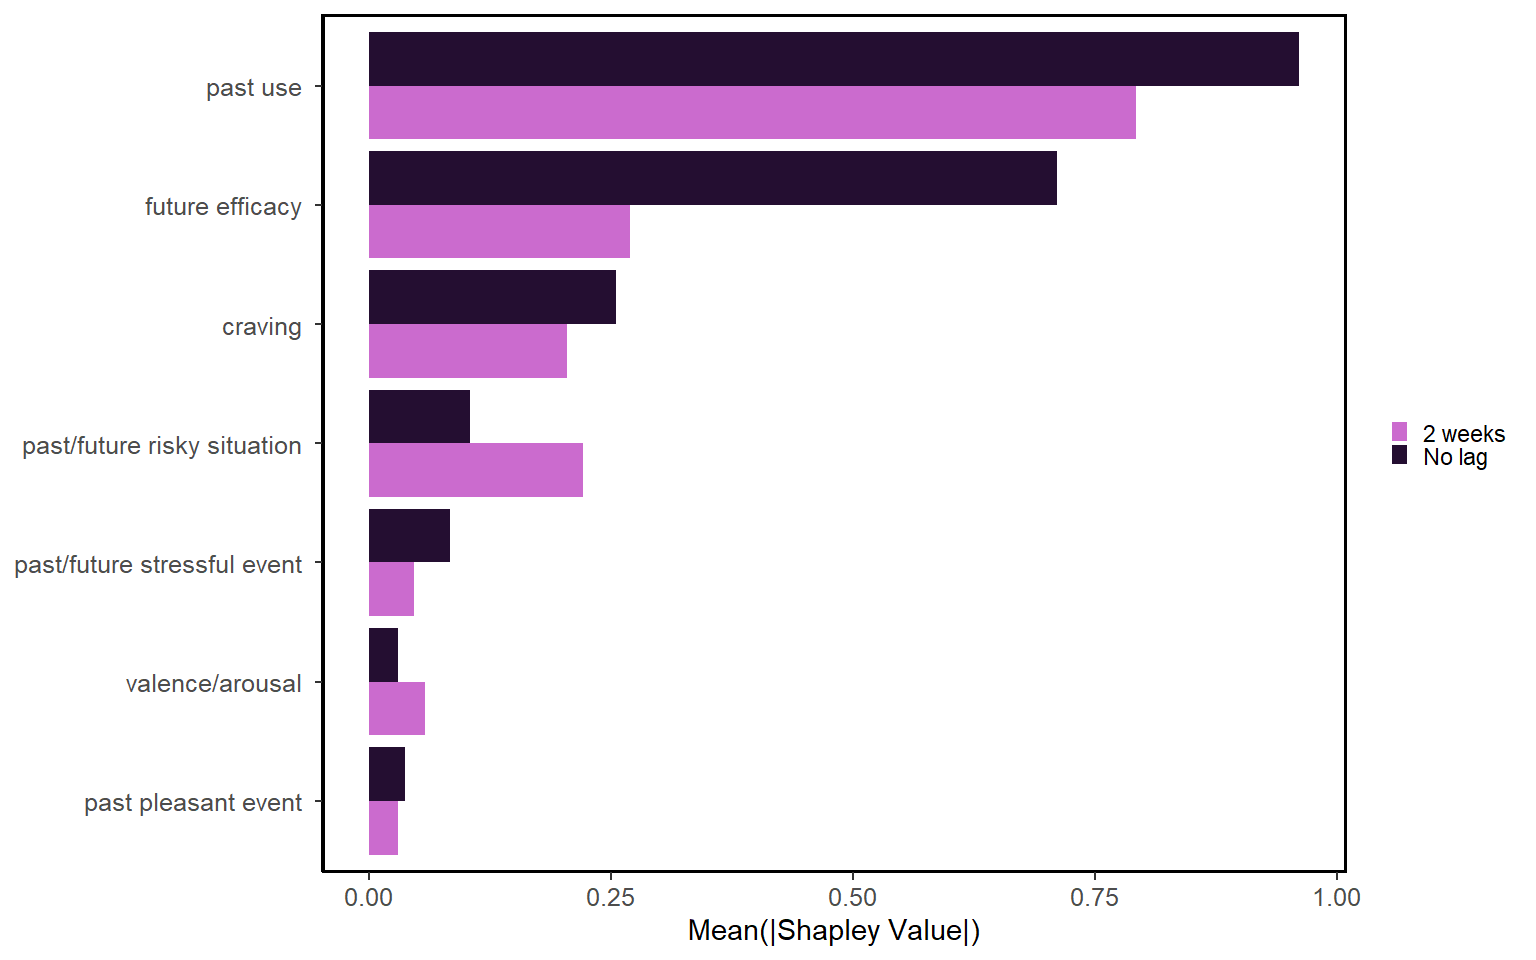

In [ ]:
#| label: fig-4
#| fig-cap: "Global feature importance (mean |Shapley value|) for feature categories for the no lag and 2-week lagged models. Feature categories are ordered by their aggregate global importance. The importance of each feature category for each model is displayed separately by color."
#| fig-width: 8
#| fig-height: 5

global_panel 